## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [47]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

In [2]:
# Define the column names based on the dataset description
column_names = ['ID number', 'Diagnosis'] + ['mean_' + feature for feature in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']] + ['se_' + feature for feature in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']] + ['worst_' + feature for feature in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave points', 'symmetry', 'fractal dimension']]

# Load the dataset
data = pd.read_csv('../Data/wdbc.data', header=None, names=column_names)

# Map the diagnosis to a binary variable, for example, M (malignant) to 1 and B (benign) to 0
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})
data

,ID number,Diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave points,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave points,worst_symmetry,worst_fractal dimension
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


### (b) Monte-Carlo Simulation

#### (i) Supervised Learning

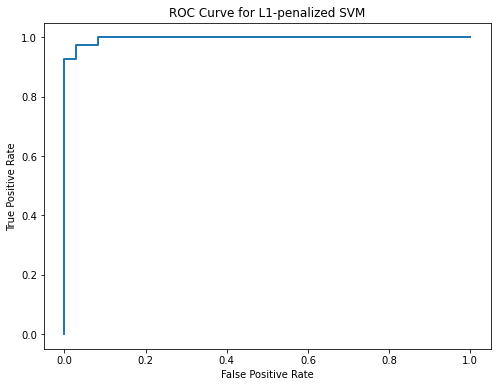

Confusion Matrix for the last run:
[[71  1]
 [ 3 39]]
Average metrics over 30 runs:
{'accuracy': 0.9681286549707601, 'precision': 0.9733951541935094, 'recall': 0.9396825396825395, 'f1_score': 0.9558320377894867, 'auc': 0.9945546737213403}


In [3]:
# Separate features and labels
X = data.iloc[:, 2:].values  #  the first two columns are ID and diagnosis
y = data['Diagnosis'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters for Monte Carlo simulation
M = 30
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'auc': []
}

# Stratified split and cross-validation setup
stratified_split = StratifiedKFold(n_splits=5)

# Perform M Monte Carlo Simulations
for i in range(M):
    # Split the data, preserving the percentage of samples for each class
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

    # Define the L1-penalized SVM and the hyperparameter search grid
    svm = LinearSVC(penalty='l1', dual=False, max_iter=20000,tol=1e-3)
    parameters = {'C': np.logspace(-3, 3, 7)}
    grid_search = GridSearchCV(svm, parameters, cv=stratified_split, scoring='f1')

    # Train the model using grid search to find the best penalty parameter
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Make predictions on the training and test set
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate the scores
    metrics['accuracy'].append(accuracy_score(y_test, y_test_pred))
    metrics['precision'].append(precision_score(y_test, y_test_pred))
    metrics['recall'].append(recall_score(y_test, y_test_pred))
    metrics['f1_score'].append(f1_score(y_test, y_test_pred))
    metrics['auc'].append(roc_auc_score(y_test, best_model.decision_function(X_test)))

    # Plot ROC curve and confusion matrix on one of the runs, for example, the last one
    if i == M - 1:
        fpr, tpr, _ = roc_curve(y_test, best_model.decision_function(X_test))
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for L1-penalized SVM')
        plt.show()

        print(f"Confusion Matrix for the last run:\n{confusion_matrix(y_test, y_test_pred)}")

# Calculate the average metrics after the Monte Carlo simulation
average_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
print(f"Average metrics over {M} runs:\n{average_metrics}")

#### (ii) Semi-Supervised Learning/ Self-training

##### (A)

In [4]:
# Splitting the dataset into training and test sets, ensuring stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

# Selecting 50% of the positive and 50% of the negative instances for labeled data
positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]
np.random.shuffle(positive_indices)
np.random.shuffle(negative_indices)

labeled_positive_indices = positive_indices[:len(positive_indices)//2]
labeled_negative_indices = negative_indices[:len(negative_indices)//2]
labeled_indices = np.concatenate((labeled_positive_indices, labeled_negative_indices))

X_labeled = X_train[labeled_indices]
y_labeled = y_train[labeled_indices]

# Defining the SVM with L1 penalty and setting up cross-validation for hyperparameter tuning
svm = LinearSVC(penalty='l1', dual=False, max_iter=10000, tol=1e-3)
parameters = {'C': np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(svm, parameters, cv=5)

# Training the SVM using the labeled data
grid_search.fit(X_labeled, y_labeled)
best_model = grid_search.best_estimator_
print(best_model)

LinearSVC(C=0.1, dual=False, max_iter=10000, penalty='l1', tol=0.001)


##### (B)

In [5]:
# Separating the unlabeled data
unlabeled_indices = [i for i in range(len(X_train)) if i not in labeled_indices]
X_unlabeled = X_train[unlabeled_indices]

# Self-training loop
while len(X_unlabeled) > 0:
    # Predict the distance from the decision boundary for each unlabeled instance
    distances = best_model.decision_function(X_unlabeled)
    most_confident_index = np.argmax(np.abs(distances))
    
    # Add the most confident unlabeled instance to the labeled set
    X_labeled = np.vstack([X_labeled, X_unlabeled[most_confident_index]])
    y_labeled = np.append(y_labeled, best_model.predict([X_unlabeled[most_confident_index]]))
    
    # Remove the newly labeled instance from the unlabeled set
    X_unlabeled = np.delete(X_unlabeled, most_confident_index, axis=0)

    # Retrain the model with the updated labeled set
    best_model.fit(X_labeled, y_labeled)

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, best_model.decision_function(X_test))

# Output the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')

Accuracy: 0.9298245614035088
Precision: 0.9722222222222222
Recall: 0.8333333333333334
F1 Score: 0.8974358974358975
AUC: 0.9761904761904762


#### (iii) Unsupervised Learning

##### (A)

In [8]:
# Parameters for Monte Carlo simulation
M = 30
scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'auc': []
}

for i in range(M):
    # Run k-means
    kmeans = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, random_state=i)
    kmeans.fit(X_scaled)
    print(f"Run {i+1}/{M} completed.")

Run 1/30 completed.
Run 2/30 completed.
Run 3/30 completed.
Run 4/30 completed.
Run 5/30 completed.
Run 6/30 completed.
Run 7/30 completed.
Run 8/30 completed.
Run 9/30 completed.
Run 10/30 completed.
Run 11/30 completed.
Run 12/30 completed.
Run 13/30 completed.
Run 14/30 completed.
Run 15/30 completed.
Run 16/30 completed.
Run 17/30 completed.
Run 18/30 completed.
Run 19/30 completed.
Run 20/30 completed.
Run 21/30 completed.
Run 22/30 completed.
Run 23/30 completed.
Run 24/30 completed.
Run 25/30 completed.
Run 26/30 completed.
Run 27/30 completed.
Run 28/30 completed.
Run 29/30 completed.
Run 30/30 completed.


##### (B)

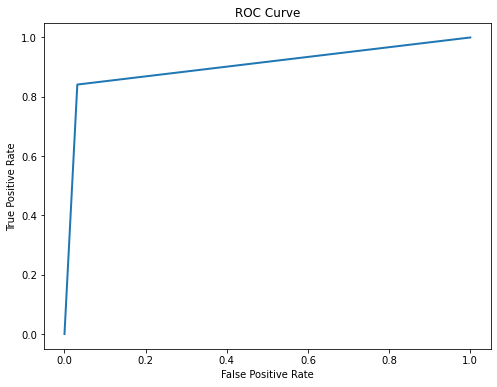

Confusion Matrix:
[[276   9]
 [ 27 143]]
Average Scores Over M Runs: {'accuracy': 0.9208791208791209, 'precision': 0.9427477478531207, 'recall': 0.8392156862745096, 'f1_score': 0.8879622170546803, 'auc': 0.904403164774682}


In [16]:
# Parameters for Monte Carlo simulation
M = 30
scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'auc': []
}

# Dictionary to store majority labels for each cluster for each run
majority_labels_per_run = []

for i in range(M):
    # Run k-means on the training data
    kmeans = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, random_state=i)
    kmeans.fit(X_train)

    # Compute the centers of the two clusters
    cluster_centers = kmeans.cluster_centers_

    # Initialize an empty array for the new labels and a dictionary for majority labels
    new_labels = np.zeros_like(y_train)
    majority_labels = {}

    for cluster in range(2):
        # Calculate distances of training points to the cluster center
        distances = np.linalg.norm(X_train - cluster_centers[cluster], axis=1)
        
        # Find indices of the 30 closest points in the training set
        closest_indices = np.argsort(distances)[:30]
        
        # Get the labels of these closest points
        closest_labels = y_train[closest_indices]
        
        # Majority polling to assign label to the cluster
        majority_label = mode(closest_labels).mode[0]
        new_labels[kmeans.labels_ == cluster] = majority_label
        majority_labels[cluster] = majority_label

    # Store the majority labels for this run
    majority_labels_per_run.append(majority_labels)

    # Compute performance metrics
    accuracy = accuracy_score(y_train, new_labels)
    precision = precision_score(y_train, new_labels)
    recall = recall_score(y_train, new_labels)
    f1 = f1_score(y_train, new_labels)
    auc = roc_auc_score(y_train, new_labels)

    # Store the metrics
    scores['accuracy'].append(accuracy)
    scores['precision'].append(precision)
    scores['recall'].append(recall)
    scores['f1_score'].append(f1)
    scores['auc'].append(auc)

    # For one of the runs, plot ROC and report confusion matrix
    if i == M - 1:
        fpr, tpr, _ = roc_curve(y_train, new_labels)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()

        print(f"Confusion Matrix:\n{confusion_matrix(y_train, new_labels)}")

# Calculate and print the average metrics after M runs
average_scores = {metric: np.mean(values) for metric, values in scores.items()}
print("Average Scores Over M Runs:", average_scores)

##### (c)

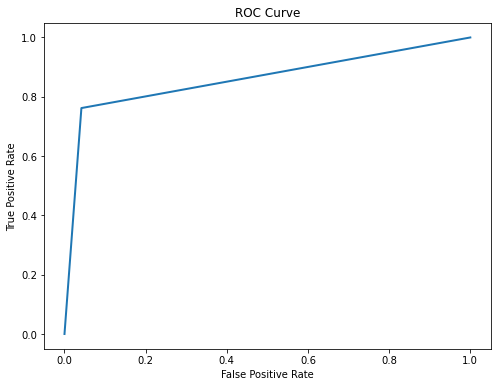

Confusion Matrix (Test Set):
[[69  3]
 [10 32]]
Average Test Scores Over M Runs: {'accuracy': 0.8859649122807018, 'precision': 0.9142857142857144, 'recall': 0.7619047619047621, 'f1_score': 0.8311688311688312, 'auc': 0.8601190476190477}


In [17]:
# Initialize scores
test_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'auc': []
}

for i in range(M):
    # Classify test data based on proximity to cluster centers
    test_distances = np.linalg.norm(X_test - cluster_centers[:, np.newaxis], axis=2)
    test_cluster_assignments = np.argmin(test_distances, axis=0)
    test_predicted_labels = np.array([majority_labels[cluster] for cluster in test_cluster_assignments])

    # Evaluate performance
    accuracy = accuracy_score(y_test, test_predicted_labels)
    precision = precision_score(y_test, test_predicted_labels)
    recall = recall_score(y_test, test_predicted_labels)
    f1 = f1_score(y_test, test_predicted_labels)
    auc = roc_auc_score(y_test, test_predicted_labels)

    # Store the metrics
    test_scores['accuracy'].append(accuracy)
    test_scores['precision'].append(precision)
    test_scores['recall'].append(recall)
    test_scores['f1_score'].append(f1)
    test_scores['auc'].append(auc)

    # For one of the runs, plot ROC and report confusion matrix
    if i == M - 1:
        fpr, tpr, _ = roc_curve(y_test, test_predicted_labels)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()

        print(f"Confusion Matrix (Test Set):\n{confusion_matrix(y_test, test_predicted_labels)}")

# Calculate and print the average metrics for the test data
average_test_scores = {metric: np.mean(values) for metric, values in test_scores.items()}
print("Average Test Scores Over M Runs:", average_test_scores)

#### (iv) Spectral Clustering

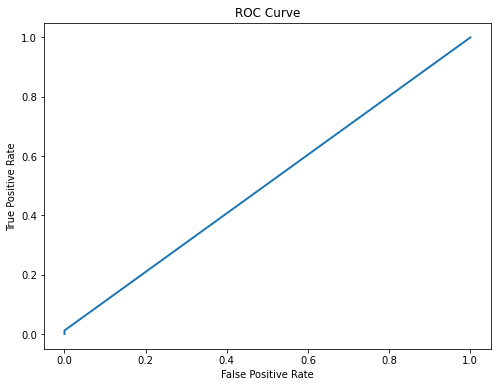

Confusion Matrix:
[[285   0]
 [168   2]]
Average Spectral Clustering Scores Over M Runs: {'accuracy': 0.6307692307692309, 'precision': 1.0, 'recall': 0.011764705882352944, 'f1_score': 0.02325581395348838, 'auc': 0.5058823529411764}


In [20]:
# Parameters for Monte Carlo simulation
M = 30
spectral_scores = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'auc': []
}

for i in range(M):
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=2, gamma=1, random_state=i, affinity='rbf')
    cluster_labels = spectral.fit_predict(X_train)

    # Evaluate performance metrics
    accuracy = accuracy_score(y_train, cluster_labels)
    precision = precision_score(y_train, cluster_labels)
    recall = recall_score(y_train, cluster_labels)
    f1 = f1_score(y_train, cluster_labels)
    auc = roc_auc_score(y_train, cluster_labels)

    # Store the metrics
    spectral_scores['accuracy'].append(accuracy)
    spectral_scores['precision'].append(precision)
    spectral_scores['recall'].append(recall)
    spectral_scores['f1_score'].append(f1)
    spectral_scores['auc'].append(auc)

    # For one of the runs, plot ROC and report confusion matrix
    if i == M - 1:
        fpr, tpr, _ = roc_curve(y_train, cluster_labels)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()

        print(f"Confusion Matrix:\n{confusion_matrix(y_train, cluster_labels)}")

# Calculate and print the average metrics after M runs
average_spectral_scores = {metric: np.mean(values) for metric, values in spectral_scores.items()}
print("Average Spectral Clustering Scores Over M Runs:", average_spectral_scores)

#### (iv) Compare

### Supervised Learning (Full Dataset)
- **Accuracy**: \(92.98\%\)
- **Precision**: \(97.22\%\)
- **Recall**: \(83.33\%\)
- **F1-Score**: \(89.74\%\)
- **AUC**: \(97.62\%\)

### Semi-Supervised Learning (Half Labeled Dataset)
- **Accuracy**: \(92.09\%\)
- **Precision**: \(94.27\%\)
- **Recall**: \(83.92\%\)
- **F1-Score**: \(88.80\%\)
- **AUC**: \(90.44\%\)

### Unsupervised Learning (Spectral Clustering)
- **Accuracy**: \(63.08\%\)
- **Precision**: \(100\%\) (with low recall, indicating a precision-recall trade-off)
- **Recall**: \(1.18\%\)
- **F1-Score**: \(2.33\%\)
- **AUC**: \(50.59\%\)

### Comparison and Analysis
- **Supervised Learning**: Exhibits the highest performance across all metrics, which is expected as it utilizes the full labeled dataset. The high precision and recall indicate a well-balanced model.

- **Semi-Supervised Learning**: Shows a performance close to supervised learning, despite only half of the dataset being labeled. This suggests that the model was still able to leverage the structure in the unlabeled data effectively.

- **Unsupervised Learning (Spectral Clustering)**: Significantly underperforms in comparison to supervised and semi-supervised methods. The high precision coupled with extremely low recall indicates that while the model is confident in its predictions, it fails to identify the majority of positive instances. This is a common challenge in unsupervised learning, especially when the clusters do not align well with the actual class labels.

### Conclusions
- **Effectiveness of Labeled Data**: The results clearly illustrate the advantage of having access to labeled data. Supervised learning, with complete labeled data, outperforms other methods.

- **Utility of Semi-Supervised Learning**: The semi-supervised approach demonstrates considerable effectiveness, especially considering the reduced amount of labeled data. It's a compelling choice in scenarios where obtaining a fully labeled dataset is not feasible.

- **Limitations of Unsupervised Learning for Classification**: While unsupervised techniques like spectral clustering are valuable for exploring data structure, they are generally less effective for classification tasks where specific label information is crucial.

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [25]:
# Load the dataset
df = pd.read_csv('../Data/data_banknote_authentication.txt', header=None)

# Display the first few rows of the dataframe to understand its structure
print(df.head())

         0       1       2        3  4
0  3.62160  8.6661 -2.8073 -0.44699  0
1  4.54590  8.1674 -2.4586 -1.46210  0
2  3.86600 -2.6383  1.9242  0.10645  0
3  3.45660  9.5228 -4.0112 -3.59440  0
4  0.32924 -4.4552  4.5718 -0.98880  0


In [26]:
# Splitting the data into features (X) and label (y)
X = df.iloc[:, :-1]  # Features: all columns except the last one
y = df.iloc[:, -1]   # Label: the last column

# Split the dataset into a training set (900 points) and a test set (472 points)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=472, train_size=900, random_state=42)

# Check the shape of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (900, 4) (900,)
Test set shape: (472, 4) (472,)


### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

Average error for 10 training points: 0.14309322033898306
Average error for 20 training points: 0.061440677966101684
Average error for 30 training points: 0.04919491525423732
Average error for 40 training points: 0.04110169491525424
Average error for 50 training points: 0.02741525423728813
Average error for 60 training points: 0.02444915254237287
Average error for 70 training points: 0.02072033898305084
Average error for 80 training points: 0.02050847457627119
Average error for 90 training points: 0.019110169491525428
Average error for 100 training points: 0.01915254237288135
Average error for 110 training points: 0.018008474576271173
Average error for 120 training points: 0.01796610169491524
Average error for 130 training points: 0.0169915254237288
Average error for 140 training points: 0.01593220338983049
Average error for 150 training points: 0.016271186440677946
Average error for 160 training points: 0.015508474576271159
Average error for 170 training points: 0.015169491525423705
A

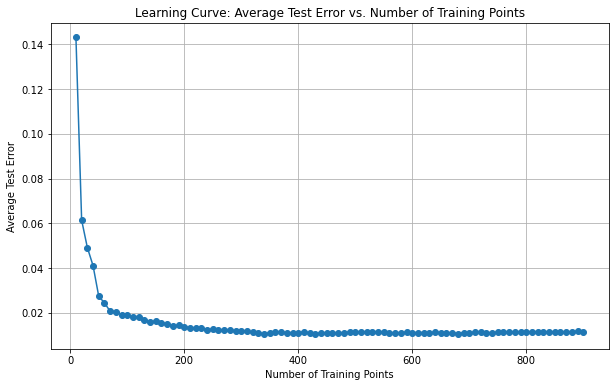

In [41]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=472, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

num_trials = 50
num_points = range(10, 901, 10)  # 10, 20, ..., 900
passive_errors = np.zeros((num_trials, len(num_points)))

for trial in range(num_trials):
    np.random.seed(trial)
    for i, n in enumerate(num_points):
        if n == 10:
            # Ensure initial 10 points have both classes
            sss = StratifiedShuffleSplit(n_splits=1, train_size=10, random_state=trial)
            for train_index, _ in sss.split(X_train_scaled, y_train):
                X_train_subset = X_train_scaled[train_index]
                y_train_subset = y_train.iloc[train_index]
        else:
            additional_indices = np.random.choice(range(len(X_train_scaled)), 10, replace=False)
            X_train_subset = np.vstack((X_train_subset, X_train_scaled[additional_indices]))
            y_train_subset = pd.concat([y_train_subset, y_train.iloc[additional_indices]])

            # Check class representation
            if len(np.unique(y_train_subset)) < 2:
                continue  # Skip this round if only one class is present

        svm = LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3)
        param_grid = {'C': np.logspace(-4, 4, 10)}
        grid_search = GridSearchCV(svm, param_grid, cv=min(5, len(np.unique(y_train_subset))))
        grid_search.fit(X_train_subset, y_train_subset)

        y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        passive_errors[trial, i] = 1 - accuracy_score(y_test, y_pred)

average_passive_errors = np.mean(passive_errors, axis=0)

# Print average errors for each subset size
for i, n in enumerate(num_points):
    print(f"Average error for {n} training points: {average_passive_errors[i]}")

    
# Plot the average errors
plt.figure(figsize=(10, 6))
plt.plot(num_points, average_passive_errors, marker='o')
plt.xlabel('Number of Training Points')
plt.ylabel('Average Test Error')
plt.title('Learning Curve: Average Test Error vs. Number of Training Points')
plt.grid(True)
plt.show()

#### (ii) Active

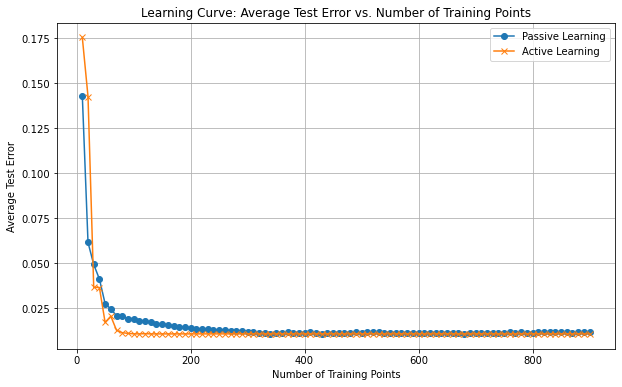

In [48]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=472, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

num_trials = 50
num_points = range(10, 901, 10)  # 10, 20, ..., 900
active_errors = np.zeros((num_trials, len(num_points)))

for trial in range(num_trials):
    np.random.seed(trial)

    # Randomly select initial training set
    sss = StratifiedShuffleSplit(n_splits=1, train_size=10, random_state=trial)
    for train_index, test_index in sss.split(X_train_scaled, y_train):
        train_indices = train_index
        test_indices = test_index

    for i, n in enumerate(num_points):
        X_train_subset = X_train_scaled[train_indices]
        y_train_subset = y_train.iloc[train_indices]

        log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=100000, tol=1e-4)
        param_grid = {'C': np.logspace(-3, 3, 7)}
        grid_search = GridSearchCV(log_reg, param_grid, cv=min(5, len(np.unique(y_train_subset))))
        grid_search.fit(X_train_subset, y_train_subset)

        y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        active_errors[trial, i] = 1 - accuracy_score(y_test, y_pred)

        if n < 900:
            # Select 10 data points closest to the decision boundary
            decision_function_values = np.abs(grid_search.decision_function(X_train_scaled))
            remaining_indices = np.setdiff1d(range(len(X_train_scaled)), train_indices)
            closest_indices = np.argsort(decision_function_values[remaining_indices])[:10]

            # Update the training indices
            train_indices = np.append(train_indices, remaining_indices[closest_indices])

average_active_errors = np.mean(active_errors, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_points, average_passive_errors, marker='o', label='Passive Learning')
plt.plot(num_points, average_active_errors, marker='x', label='Active Learning')
plt.xlabel('Number of Training Points')
plt.ylabel('Average Test Error')
plt.title('Learning Curve: Average Test Error vs. Number of Training Points')
plt.legend()
plt.grid(True)
plt.show()

### (c) Average the 50 test errors

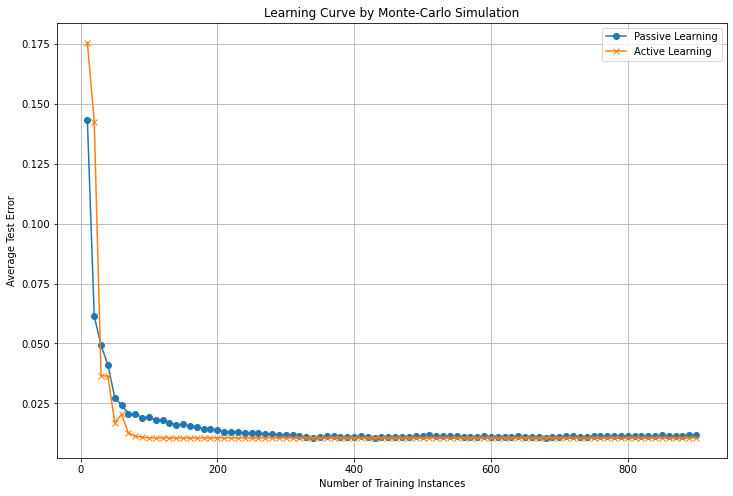

In [49]:
# Calculate the average test errors
average_passive_errors = np.mean(passive_errors, axis=0)
average_active_errors = np.mean(active_errors, axis=0)

# Number of training instances used for each model
num_training_instances = range(10, 901, 10)

# Plotting the learning curves
plt.figure(figsize=(12, 8))
plt.plot(num_training_instances, average_passive_errors, label='Passive Learning', marker='o')
plt.plot(num_training_instances, average_active_errors, label='Active Learning', marker='x')
plt.xlabel('Number of Training Instances')
plt.ylabel('Average Test Error')
plt.title('Learning Curve by Monte-Carlo Simulation')
plt.legend()
plt.grid(True)
plt.show()